<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TFDS/FeatureColumns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Pipeline

### Setup

We'll start by importing TensorFlow and TensorFlow Datasets.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.filterwarnings('ignore')

import numpy as np
np.random.seed(42)

import pandas as pd
import json

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set(font='DejaVu Sans')

from sklearn.model_selection import train_test_split 

import tensorflow as tf
tf.keras.utils.set_random_seed(42)
tf.get_logger().setLevel('ERROR')

import tensorflow_datasets as tfds

print("\u2022 Using Tensorflow Version:", tf.__version__)

• Using Tensorflow Version: 2.12.0


### Using an iterator to navigate

In [2]:
dataset = tf.data.Dataset.from_tensor_slices(
    tensors=[1, 2, 3, 4]
)
it = iter(dataset)

while True:
    try:
        print(next(it))
    except StopIteration as e:
        break

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


### Loading numpy arrays

In [2]:
(x_train, y_train), (x_test, y_test) = \
    tf.keras.datasets.cifar10.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(x_train, y_train))

for image, label in tfds.as_numpy(dataset.take(2)):
    print(image.shape, label)

170498071/170498071 [==============================] - 3316s 19us/step
(32, 32, 3) [6]
(32, 32, 3) [9]


### Numeric column

In [ ]:
# Specifying data types
# Represent a tf.float64 scalar.
numeric_feature_column = tf.feature_column.numeric_column(
    key="SepalLength", dtype=tf.float64)

# Represent a 10-element vector 
# in which each cell contains a tf.float32
vector_feature_column = tf.feature_column.numeric_column(
    key="Bowling", shape=10)

# Represent a 10x5 matrix in which each cell contains a tf.float32.
matrix_feature_column = tf.feature_column.numeric_column(
    key="MyMatrix", shape=[10, 5])

### Bucketizing features

In [ ]:
# First, convert the raw input to a numeric column.
numeric_feature_column = tf.feature_column.numeric_column(
    key="Year")

# Then, bucketize the numeric column 
# on the years 1960, 1980, and 2000.
bucketized_feature_column = tf.feature_column.bucketized_column(
    source_column=numeric_feature_column,
    boundaries=[1960, 1980, 2000])

### Categorical identity features

In [ ]:
identity_feature_column = \
    tf.feature_column.categorical_column_with_identity(
        key='my_feature_b', num_buckets=4) # Values [0, 4]

def input_fn():
    ...
    return ({'my_feature_a': [7, 9, 5, 2],
        'my_feature_b': [3, 1, 2, 2]}, [Label_values])

### Categorical vocabulary column

In [ ]:
# From a vocabulary list
vocabulary_feature_column = \
    tf.feature_column.categorical_column_with_vocabulary_list(
        key=feature_name,
        vocabulary_list=['kitchenware', 'electronics', 'sports'])

# From a vocabulary file
vocabulary_feature_column = \
    tf.feature_column.categorical_column_with_vocabulary_file(
        key=feature_name, vocabulary_file='product_class.txt',
        vocabulary_size=3)

### Hashed column

In [ ]:
# hash(raw_feature) % hash_bucket_size
hashed_feature_column = \
    tf.feature_column.categorical_column_with_hash_bucket(
        key="some_feature",
        hash_bucket_size=100) # The number of categories

### Crossed column

In [ ]:
# Bucketize the latitude and longitude using the `edges`
latitude_bucket_fc = tf.feature_column.bucketized_column(
    source_column=tf.feature_column.numeric_column(key='latitude'),
    boundaries=list(atlanta.latitude.edges))

longitude_bucket_fc = tf.feature_column.bucketized_column(
    source_column=tf.feature_column.numeric_column(key='longitude'),
    boundaries=list(atlanta.longitude.edges))

# Cross the bucketized columns, using 5000 hash bins.
crossed_lat_lon_fc = tf.feature_column.crossed_column(
    keys=[latitude_bucket_fc, longitude_bucket_fc],
    hash_bucket_size=5000)

### Embedding column

In [ ]:
embedding_dimensions = number_of_categories**0.25
categorical_column = ... # Create any categorical column

# Represent the categorical column as an embedding column.
# This means creating an embedding vector lookup table with
# one element for each category.
embedding_column = tf.feature_column.embedding_column(
    categorical_column=categorical_column,
    dimension=embedding_dimensions)

## Classify structured data with feature columns

> Warning: The `tf.feature_columns` module described in this tutorial is not recommended for new code. [Keras preprocessing layers](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers) cover this functionality, for migration instructions see the [Migrating feature columns](../../guide/migrate/migrating_feature_columns.ipynb) guide. The `tf.feature_columns` module was designed for use with TF1 `Estimators`. It does fall under our [compatibility guarantees](https://tensorflow.org/guide/versions), but will receive no fixes other than security vulnerabilities.

This tutorial demonstrates how to classify structured data (e.g. tabular data in a CSV). We will use [Keras](https://www.tensorflow.org/guide/keras) to define the model, and `tf.feature_column` as a bridge to map from columns in a CSV to features used to train the model. This tutorial contains complete code to:

* Load a CSV file using [Pandas](https://pandas.pydata.org/).
* Build an input pipeline to batch and shuffle the rows using [tf.data](https://www.tensorflow.org/guide/datasets).
* Map from columns in the CSV to features used to train the model using feature columns.
* Build, train, and evaluate a model using Keras.

### The Dataset

We will use a simplified version of the PetFinder [dataset](https://www.kaggle.com/c/petfinder-adoption-prediction). There are several thousand rows in the CSV. Each row describes a pet, and each column describes an attribute. We will use this information to predict the speed at which the pet will be adopted.

Following is a description of this dataset. Notice there are both numeric and categorical columns. There is a free text column which we will not use in this tutorial.

Column | Description| Feature Type | Data Type
------------|--------------------|----------------------|-----------------
Type | Type of animal (Dog, Cat) | Categorical | string
Age |  Age of the pet | Numerical | integer
Breed1 | Primary breed of the pet | Categorical | string
Color1 | Color 1 of pet | Categorical | string
Color2 | Color 2 of pet | Categorical | string
MaturitySize | Size at maturity | Categorical | string
FurLength | Fur length | Categorical | string
Vaccinated | Pet has been vaccinated | Categorical | string
Sterilized | Pet has been sterilized | Categorical | string
Health | Health Condition | Categorical | string
Fee | Adoption Fee | Numerical | integer
Description | Profile write-up for this pet | Text | string
PhotoAmt | Total uploaded photos for this pet | Numerical | integer
AdoptionSpeed | Speed of adoption | Classification | integer

### Use Pandas to create a dataframe

[Pandas](https://pandas.pydata.org/) is a Python library with many helpful utilities for loading and working with structured data. We will use Pandas to download the dataset from a URL, and load it into a dataframe.

In [2]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
tf.keras.utils.get_file(
    fname='petfinder_mini.zip', origin=dataset_url,
    extract=True, cache_dir='~')

csv_file = '~/datasets/petfinder-mini/petfinder-mini.csv'
dataframe = pd.read_csv(csv_file)

dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


### Create target variable

The task in the original dataset is to predict the speed at which a pet will be adopted (e.g., in the first week, the first month, the first three months, and so on). Let's simplify this for our tutorial. Here, we will transform this into a binary classification problem, and simply predict whether the pet was adopted, or not.

After modifying the label column, 0 will indicate the pet was not adopted, and 1 will indicate it was.

In [3]:
# In the original dataset "4" indicates the pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop un-used columns.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,1


### Split the dataframe into train, validation, and test

The dataset we downloaded was a single CSV file. We will split this into train, validation, and test sets.

In [4]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

7383 train examples
1846 validation examples
2308 test examples


### Create an input pipeline using tf.data

Next, we will wrap the dataframes with [tf.data](https://www.tensorflow.org/guide/datasets). This will enable us  to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly. That is not covered in this tutorial.

In [5]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices(
        tensors=(dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size=batch_size)
    return ds

In [6]:
# A small batch sized is used for demonstration purposes
batch_size = 5
train_ds = df_to_dataset(
    dataframe=train, batch_size=batch_size)
val_ds = df_to_dataset(
    dataframe=val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(
    dataframe=test, shuffle=False, batch_size=batch_size)

### Understand the input pipeline

Now that we have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable.

In [7]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['Age'])
    print('A batch of targets:', label_batch)

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor([ 3  1 54 36 18], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)


We can see that the dataset returns a dictionary of column names (from the dataframe) that map to column values from rows in the dataframe.

### Demonstrate several types of feature columns
TensorFlow provides many types of feature columns. In this section, we will create several types of feature columns, and demonstrate how they transform a column from the dataframe.

In [8]:
# We will use this batch to demonstrate several types 
# of feature columns
example_batch = next(iter(train_ds))[0]
example_batch

{'Type': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Cat', b'Dog', b'Dog', b'Dog', b'Cat'], dtype=object)>,
 'Age': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 5,  3,  2, 10, 10])>,
 'Breed1': <tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'Domestic Medium Hair', b'Mixed Breed', b'Toy Fox Terrier',
        b'Mixed Breed', b'Domestic Short Hair'], dtype=object)>,
 'Gender': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Male', b'Male', b'Female', b'Male', b'Male'], dtype=object)>,
 'Color1': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Yellow', b'Brown', b'Black', b'Golden', b'Brown'], dtype=object)>,
 'Color2': <tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'White', b'White', b'Brown', b'No Color', b'No Color'],
       dtype=object)>,
 'MaturitySize': <tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'Medium', b'Medium', b'Medium', b'Medium', b'Medium'],
       dtype=object)>,
 'FurLength': <tf.Tensor: shape=(5,), dtype=string, numpy=arra

In [9]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_columns):
    feature_layer = tf.keras.layers.DenseFeatures(
        feature_columns=feature_columns)
    print(feature_layer(example_batch).numpy())

#### Numeric columns
The output of a feature column becomes the input to the model (using the demo function defined above, we will be able to see exactly how each column from the dataframe is transformed). A [numeric column](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column) is the simplest type of column. It is used to represent real valued features. When using this column, your model will receive the column value from the dataframe unchanged.

In [10]:
photo_count = tf.feature_column.numeric_column(key='PhotoAmt')
demo(photo_count)

[[2.]
 [5.]
 [4.]
 [1.]
 [1.]]


In the PetFinder dataset, most columns from the dataframe are categorical.

#### Bucketized columns
Often, you don't want to feed a number directly into the model, but instead split its value into different categories based on numerical ranges. Consider raw data that represents a person's age. Instead of representing age as a numeric column, we could split the age into several buckets using a [bucketized column](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column). Notice the one-hot values below describe which age range each row matches.

In [11]:
age_buckets = tf.feature_column.bucketized_column(
    source_column=tf.feature_column.numeric_column(key='Age'),
    boundaries=[1, 3, 5])
demo(age_buckets)

[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


#### Categorical columns
In this dataset, Type is represented as a string (e.g. 'Dog', or 'Cat'). We cannot feed strings directly to a model. Instead, we must first map them to numeric values. The categorical vocabulary columns provide a way to represent strings as a one-hot vector (much like you have seen above with age buckets). The vocabulary can be passed as a list using [categorical_column_with_vocabulary_list](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list), or loaded from a file using [categorical_column_with_vocabulary_file](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_file).

In [12]:
animal_type = \
    tf.feature_column.categorical_column_with_vocabulary_list(
        key='Type', vocabulary_list=['Cat', 'Dog'])

animal_type_one_hot = tf.feature_column.indicator_column(
    categorical_column=animal_type)
demo(animal_type_one_hot)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


#### Embedding columns
Suppose instead of having just a few possible strings, we have thousands (or more) values per category. For a number of reasons, as the number of categories grow large, it becomes infeasible to train a neural network using one-hot encodings. We can use an embedding column to overcome this limitation. Instead of representing the data as a one-hot vector of many dimensions, an [embedding column](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column) represents that data as a lower-dimensional, dense vector in which each cell can contain any number, not just 0 or 1. The size of the embedding (8, in the example below) is a parameter that must be tuned.

Key point: using an embedding column is best when a categorical column has many possible values. We are using one here for demonstration purposes, so you have a complete example you can modify for a different dataset in the future.

In [14]:
# Notice the input to the embedding column is the categorical column
# we previously created
breed1 = tf.feature_column.categorical_column_with_vocabulary_list(
      key='Breed1', vocabulary_list=dataframe.Breed1.unique())

breed1_embedding = tf.feature_column.embedding_column(
    categorical_column=breed1, dimension=8)
demo(breed1_embedding)

[[-0.3873489   0.10392997  0.22482936  0.2373078  -0.0113741   0.3977393
   0.09797043  0.07564942]
 [-0.12034053 -0.35094115 -0.16476142  0.10040782 -0.40124777 -0.24146378
  -0.56392556 -0.23805983]
 [ 0.177751    0.0084844   0.23009194 -0.05076086  0.03283119  0.2222727
   0.23129591 -0.4312865 ]
 [-0.12034053 -0.35094115 -0.16476142  0.10040782 -0.40124777 -0.24146378
  -0.56392556 -0.23805983]
 [-0.23385933  0.28508824  0.4337364  -0.08634241 -0.29507527 -0.47450152
  -0.12360551 -0.20035566]]


#### Hashed feature columns

Another way to represent a categorical column with a large number of values is to use a [categorical_column_with_hash_bucket](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_hash_bucket). This feature column calculates a hash value of the input, then selects one of the `hash_bucket_size` buckets to encode a string. When using this column, you do not need to provide the vocabulary, and you can choose to make the number of hash_buckets significantly smaller than the number of actual categories to save space.

Key point: An important downside of this technique is that there may be collisions in which different strings are mapped to the same bucket. In practice, this can work well for some datasets regardless.

In [15]:
breed1_hashed = tf.feature_column.categorical_column_with_hash_bucket(
    key='Breed1', hash_bucket_size=10)

breed1_one_hot = tf.feature_column.indicator_column(
    categorical_column=breed1_hashed)
demo(breed1_one_hot)

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


#### Crossed feature columns
Combining features into a single feature, better known as [feature crosses](https://developers.google.com/machine-learning/glossary/#feature_cross), enables a model to learn separate weights for each combination of features. Here, we will create a new feature that is the cross of Age and Type. Note that `crossed_column` does not build the full table of all possible combinations (which could be very large). Instead, it is backed by a `hashed_column`, so you can choose how large the table is.

In [16]:
crossed_feature = tf.feature_column.crossed_column(
    keys=[age_buckets, animal_type], hash_bucket_size=10)
crossed_feature_one_hot = tf.feature_column.indicator_column(
    categorical_column=crossed_feature)
demo(crossed_feature_one_hot)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Choose which columns to use
We have seen how to use several types of feature columns. Now we will use them to train a model. The goal of this tutorial is to show you the complete code (e.g. mechanics) needed to work with feature columns. We have selected a few columns to train our model below arbitrarily.

Key point: If your aim is to build an accurate model, try a larger dataset of your own, and think carefully about which features are the most meaningful to include, and how they should be represented.

In [17]:
feature_columns = []

# numeric cols
for header in ['PhotoAmt', 'Fee', 'Age']:
    feature_columns.append(
        tf.feature_column.numeric_column(key=header))

In [18]:
# bucketized cols
age_buckets = tf.feature_column.bucketized_column(
    source_column=tf.feature_column.numeric_column(key='Age'),
    boundaries=[1, 2, 3, 4, 5])
feature_columns.append(age_buckets)

In [19]:
# indicator_columns
indicator_column_names = [
    'Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
    'FurLength', 'Vaccinated', 'Sterilized', 'Health'
]
for col_name in indicator_column_names:
    categorical_column = \
        tf.feature_column.categorical_column_with_vocabulary_list(
            key=col_name,
            vocabulary_list=dataframe[col_name].unique())
    indicator_column = tf.feature_column.indicator_column(
        categorical_column=categorical_column)
    feature_columns.append(indicator_column)

In [20]:
# embedding columns
breed1 = tf.feature_column.categorical_column_with_vocabulary_list(
    key='Breed1', vocabulary_list=dataframe.Breed1.unique())
breed1_embedding = tf.feature_column.embedding_column(
    categorical_column=breed1, dimension=8)
feature_columns.append(breed1_embedding)

In [21]:
# crossed columns
age_type_feature = tf.feature_column.crossed_column(
    keys=[age_buckets, animal_type], hash_bucket_size=100)
feature_columns.append(
    tf.feature_column.indicator_column(
        categorical_column=age_type_feature))

### Create a feature layer
Now that we have defined our feature columns, we will use a [DenseFeatures](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/DenseFeatures) layer to input them to our Keras model.

In [22]:
feature_layer = tf.keras.layers.DenseFeatures(
    feature_columns=feature_columns)

Earlier, we used a small batch size to demonstrate how feature columns worked. We create a new input pipeline with a larger batch size.

In [23]:
batch_size = 32
train_ds = df_to_dataset(dataframe=train, batch_size=batch_size)
val_ds = df_to_dataset(dataframe=val, shuffle=False,
    batch_size=batch_size)
test_ds = df_to_dataset(dataframe=test, shuffle=False,
    batch_size=batch_size)

### Create, compile, and train the model

In [24]:
model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(units=128,
        activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=128,
        activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(rate=.1),
    tf.keras.layers.Dense(units=1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

history = model.fit(x=train_ds,
    validation_data=val_ds,
    epochs=10, verbose=0)

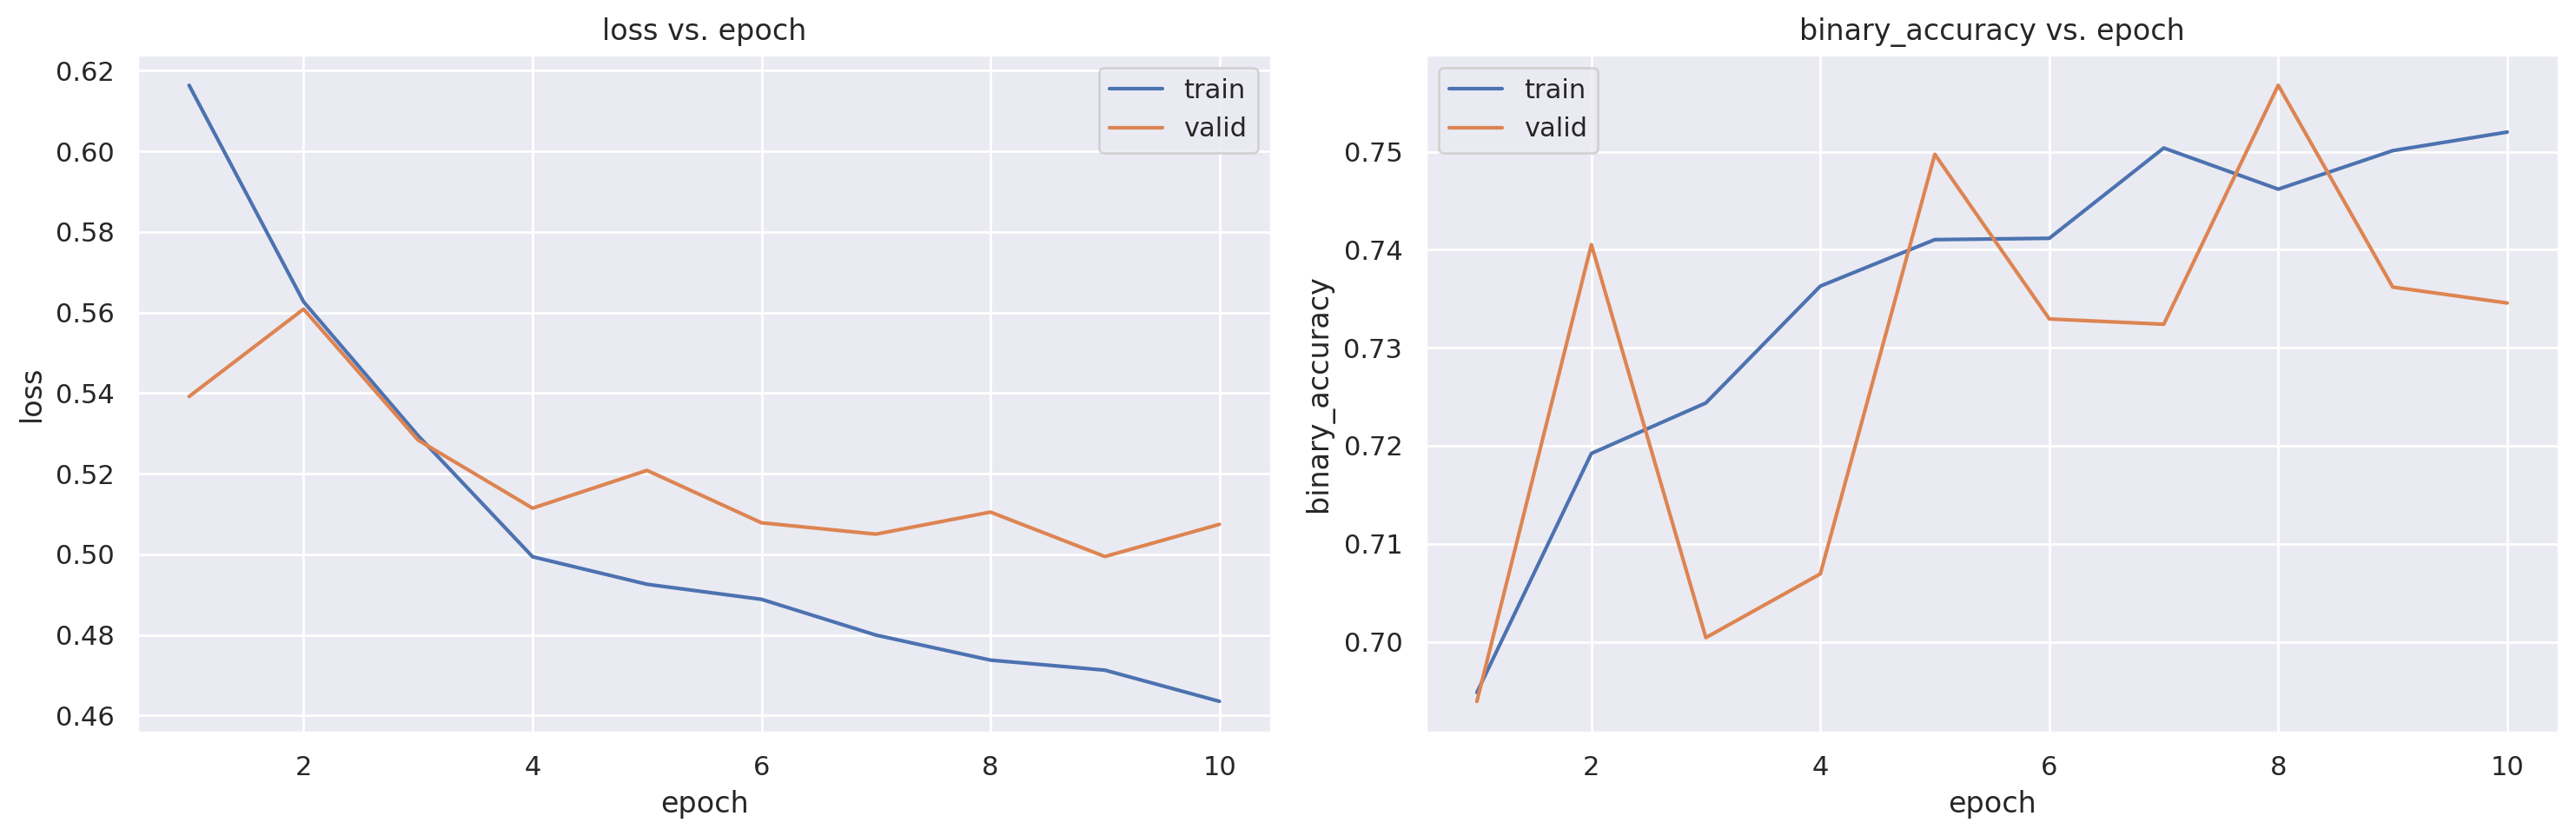

test loss: 0.51,    test accuracy: 0.73


In [27]:
df_history = pd.DataFrame(data=history.history, index=history.epoch)
metrics = ['loss', 'binary_accuracy']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for ax, metric in zip(axes, metrics):
    sns.lineplot(ax=ax, data=df_history,
        x=df_history.index+1, y=metric, label='train')
    try:
        sns.lineplot(ax=ax, data=df_history,
            x=df_history.index+1, y=f'val_{metric}', label='valid')
    except Exception:
        pass
    ax.legend(loc='best')
    ax.set_xlabel('epoch')
    ax.set_ylabel(f'{metric}')
    ax.set_title(f"{metric} vs. epoch")
fig.tight_layout()
plt.show()

test_loss, test_accuracy = model.evaluate(x=test_ds, verbose=0)
print(f"test loss: {test_loss:.2f},\
    test accuracy: {test_accuracy:.2f}")

Key point: You will typically see best results with deep learning with much larger and more complex datasets. When working with a small dataset like this one, we recommend using a decision tree or random forest as a strong baseline. The goal of this tutorial is not to train an accurate model, but to demonstrate the mechanics of working with structured data, so you have code to use as a starting point when working with your own datasets in the future.

### Next steps
The best way to learn more about classifying structured data is to try it yourself. We suggest finding another dataset to work with, and training a model to classify it using code similar to the above. To improve accuracy, think carefully about which features to include in your model, and how they should be represented.

## Extracting and Loading Data to Pipelines

### Loading a dataset from npz

In [4]:
# Download dataset
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'
path = tf.keras.utils.get_file(fname='mnist.npz', origin=DATA_URL)

# Extract train and test examples
with np.load(path) as data:
    train_examples = data['x_train']
    train_labels = data['y_train']
    test_examples = data['x_test']
    test_labels = data['y_test']
    
# Create train and test datasets out of the examples
train_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(train_examples, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(test_examples, test_labels))

for feat, targ in train_dataset.take(2):
    print('Features shape: {}, Target: {}'.format(feat.shape, targ))

Features shape: (28, 28), Target: 5
Features shape: (28, 28), Target: 0
